# Prediction of drug release using FC-NN-GRU
## Initialize environment and variables
There are 321 samples in the Bao et al (2025) dataset, we use 11 material input features from the dataset. Our approach normalizes and interpolates the release curve prior to prediction. The FC-NN-GRU model's hyperparameters and optimized using 10x2 cross validation and 50 Optuna trials per fold. 

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
import optuna.visualization as vis
import random
import os
from optuna.samplers import TPESampler
import warnings
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore")
# ----------------------------------------------------------------------------------------
# Setup
# ----------------------------------------------------------------------------------------
total_samples = 321
num_interp_pts = 11
num_features = 11
inner_epochs = 250
outer_epochs = 500
n_outer_folds = 10
n_inner_folds = 2
n_trials = 50
hidden_dim1=32
hidden_dim2=64
input_dim = num_features
seq_len = num_interp_pts
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Filenames ===
model_name = "FC-NN-GRU"
inner_loss_filename = f"{model_name}_inner_loss.csv"
outer_loss_filename = f"{model_name}_outer_loss.csv"
inputs_filename = f"{model_name}_inputs.csv"
preds_filename = f"{model_name}_preds_vs_targets.csv"
metrics_filename = f"{model_name}_metrics_summary.csv"

# ----------------------
# Load data
# ----------------------
file_path_form = 'mp_dataset_processed_no_dupes.xlsx'
file_path_time = 'mp_dataset_processed_time_release_only.xlsx'
formulation_df = pd.read_excel(file_path_form, engine='openpyxl')
release_df = pd.read_excel(file_path_time, engine='openpyxl')


Using device: cpu


## Data preparation
Dataframe input encoding, drug release curve interpolation and normalization. Duplcation of input features and insertion of time column. 

In [15]:
# ----------------------------------------------------------------------------------------
# Encode categorical
# ----------------------------------------------------------------------------------------
unique_values_emulsion = formulation_df['Formulation Method'].unique()
mapping = {v: i for i, v in enumerate(unique_values_emulsion)}
formulation_df['Formulation Method Encoded'] = formulation_df['Formulation Method'].map(mapping)
formulation_df.drop(columns=['Formulation Method', 'Drug SMILES'], inplace=True)

# ----------------------------------------------------------------------------------------
# Interpolation
# ----------------------------------------------------------------------------------------
group = release_df.groupby('Formulation Index')['Time']
min_time = group.transform('min')
max_time = group.transform('max')
release_df['Normalized Time'] = (release_df['Time'] - min_time) / (max_time - min_time)
normalized_times = np.linspace(0, 1, num_interp_pts)
interpolated_dfs = []
for formulation, g in release_df.groupby('Formulation Index'):
    g = g.sort_values('Time')
    time_min, time_max = g['Time'].min(), g['Time'].max()
    g['Normalized Time'] = (g['Time'] - time_min) / (time_max - time_min)
    interp_release = np.interp(normalized_times, g['Normalized Time'], g['Release'])
    interpolated_dfs.append(pd.DataFrame({
        'Formulation Index': formulation,
        'Normalized Time': normalized_times,
        'Interpolated Release': interp_release
    }))
interp_df = pd.concat(interpolated_dfs, ignore_index=True)

X = formulation_df.drop(columns=['Formulation Index']).to_numpy()
groups = interp_df.groupby('Formulation Index')['Interpolated Release']
y = np.stack([g.to_numpy().reshape(-1, 1) for _, g in groups]) # [321, 11, 1]



## Model definition

In [16]:
class CustomMLPWithEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_rate=0.2):
        super(CustomMLPWithEmbedding, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # 11 -> 32
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # 32 -> 64
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))  # [batch, 32]
        x = self.dropout2(self.relu2(self.fc2(x)))  # [batch, 64]
        return x  # embedding: [batch, 64]


def repeat_embedding(embeddings, repeat_len=num_interp_pts):
    # embeddings: [batch_size, emb_dim]
    # returns: [batch_size, repeat_len, emb_dim]
    return embeddings.unsqueeze(1).repeat(1, repeat_len, 1)  # [batch, seq_len, emb_dim]


class MLPGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,
                 gru_hidden_dim, gru_layers, output_dim, dropout_rate=0.2):
        super(MLPGRU, self).__init__()

        self.embedding_mlp = CustomMLPWithEmbedding(input_dim, hidden_dim1, hidden_dim2, dropout_rate)
        
        self.gru = nn.GRU(input_size=hidden_dim2,
                          hidden_size=gru_hidden_dim,
                          num_layers=gru_layers,
                          dropout=dropout_rate if gru_layers > 1 else 0,
                          batch_first=True)
        
        # Fully connected layers after GRU
        self.fc1 = nn.Linear(gru_hidden_dim, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 1)  

    def forward(self, x):
        # x: [batch_size, input_dim]
        emb = self.embedding_mlp(x)  # [batch_size, hidden_dim2=64]

        emb_seq = repeat_embedding(emb, repeat_len=num_interp_pts)  # [batch_size, seq_len, 64]

        gru_out, _ = self.gru(emb_seq)  # [batch_size, seq_len, gru_hidden_dim]

        x = self.dropout1(self.relu1(self.fc1(gru_out)))   # [batch, seq_len, 32]
        output = self.fc2(x)                                # [batch, seq_len, 1]

        return output

## Model optimization

In [17]:
# ----------------------------------------------------------------------------------------
# Storage
# ----------------------------------------------------------------------------------------
all_outer_train_loss_curves_best = []
stored_best_models = []
stored_best_mse = []
stored_best_rmse = []
stored_best_preds = []
stored_test_targets = []
stored_r2 = []
stored_adj_r2 = []

# ----------------------------------------------------------------------------------------
# Nested CV
# ----------------------------------------------------------------------------------------
outer_kf = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)
outer_scores = []

# ----------------------------------------------------------------------------------------
# === Optuna objective function for inner loop ===
# ----------------------------------------------------------------------------------------
def objective(trial, X_train_val, y_train_val):
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    num_layers = trial.suggest_categorical("num_layers", [1, 2, 3])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.3, 0.4])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-4])
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

    inner_scores = []
    best_epochs_inner = []

    for inner_fold, (train_idx, val_idx) in enumerate(inner_kf.split(X_train_val)):
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_val[train_idx])
        X_val_scaled = scaler.transform(X_train_val[val_idx])


        # Tensors
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_val[train_idx], dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_train_val[val_idx], dtype=torch.float32).to(device)

        # Model
        model =  MLPGRU(
                input_dim=num_features,
                hidden_dim1=hidden_dim1,
                hidden_dim2=hidden_dim2,
                gru_hidden_dim=hidden_size,
                gru_layers=num_layers,
                output_dim=1,
                dropout_rate=dropout
            ).to(device) 
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Dataloaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

        # --- Train for fixed number of epochs (NO EARLY STOPPING) ---
        for epoch in range(inner_epochs):
            model.train()
            for xb, yb in train_loader:
                pred = model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # --- Final validation loss ---
        model.eval()
        val_loss_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss_total += loss.item()

        inner_scores.append(val_loss_total / len(val_loader))

    # Return mean validation MSE across all inner folds
    return float(np.mean(inner_scores)) 

# === Outer loop ===
for outer_fold, (train_val_idx, test_idx) in enumerate(outer_kf.split(np.arange(total_samples))):
    print(f"\n===== OUTER FOLD {outer_fold+1} =====")
    X_train_val, y_train_val = X[train_val_idx], y[train_val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # ----------------------------------------------------------------------------------------
    # Run Optuna study
    # ----------------------------------------------------------------------------------------
    tpe_sampler = TPESampler(seed=42) 
    study = optuna.create_study(direction="minimize", sampler=tpe_sampler)
    study.optimize(lambda trial: objective(trial, X_train_val, y_train_val), n_trials=n_trials)
    best_params = study.best_params
    print("Best params:", best_params)
    # ----------------------------------------------------------------------------------------
    # Train best model on full training data
    # ----------------------------------------------------------------------------------------
    scaler = StandardScaler()
    X_train_val_scaled = scaler.fit_transform(X_train_val)
    X_test_scaled = scaler.transform(X_test)
    X_train_tensor = torch.tensor(X_train_val_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_val, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Initialize model with best params
    outer_model =  MLPGRU(
        input_dim=num_features,
        hidden_dim1=hidden_dim1,
        hidden_dim2=hidden_dim2,
        gru_hidden_dim=study.best_params["hidden_size"],
        gru_layers=study.best_params["num_layers"],
        output_dim=1,
        dropout_rate=study.best_params["dropout"]
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(outer_model.parameters(), lr=best_params["lr"])

    # Train outer model
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params["batch_size"])
    train_losses_best = []

    for epoch in range(outer_epochs):
        outer_model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            output = outer_model(xb)
            loss = criterion(output, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses_best.append(epoch_loss / len(train_loader))

    all_outer_train_loss_curves_best.append(train_losses_best)

    # Evaluate on test set
    outer_model.eval()
    with torch.no_grad():
        y_pred = outer_model(X_test_tensor)
        y_pred_np = y_pred.cpu().numpy().squeeze()
        y_test_np = y_test_tensor.cpu().numpy().squeeze()

        # Metrics
        best_mse = np.mean((y_pred_np - y_test_np) ** 2)
        best_rmse = np.sqrt(best_mse)
        r2 = r2_score(y_test_np.flatten(), y_pred_np.flatten())
        n = len(y_test_np.flatten())
        p = X.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

        # Store
        stored_best_mse.append(best_mse)
        stored_best_rmse.append(best_rmse)
        # Flatten to 1D for easy stacking later
        stored_best_preds.append(y_pred_np.flatten())
        stored_test_targets.append(y_test_np.flatten())
        stored_r2.append(r2)
        stored_adj_r2.append(adj_r2)
        stored_best_models.append(outer_model)
        outer_scores.append(best_rmse)

    print(f"Outer Fold {outer_fold+1} MSE: {best_mse:.4f}, RMSE: {best_rmse:.4f}, R²: {r2:.4f}, Adj R²: {adj_r2:.4f}")

# Final nested CV summary
print(f"\nFinal Nested CV RMSE: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
print(f"\nFinal Adj R²: {np.mean(stored_adj_r2):.4f} ± {np.std(stored_adj_r2):.4f}")



===== OUTER FOLD 1 =====
Best params: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128}
Outer Fold 1 MSE: 0.0257, RMSE: 0.1602, R²: 0.7452, Adj R²: 0.7372

===== OUTER FOLD 2 =====
Best params: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 16}
Outer Fold 2 MSE: 0.0134, RMSE: 0.1159, R²: 0.8654, Adj R²: 0.8610

===== OUTER FOLD 3 =====
Best params: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128}
Outer Fold 3 MSE: 0.0284, RMSE: 0.1685, R²: 0.7238, Adj R²: 0.7149

===== OUTER FOLD 4 =====
Best params: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}
Outer Fold 4 MSE: 0.0261, RMSE: 0.1615, R²: 0.7341, Adj R²: 0.7255

===== OUTER FOLD 5 =====
Best params: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 128}
Outer Fold 5 MSE: 0.0169, RMSE: 0.1299, R²: 0.8316, Adj R²: 0.8262

===== OUTER FOLD 6 =====
Best params: {'h

## Visualize predictions

Saved FC-NN-GRU_prediction.png


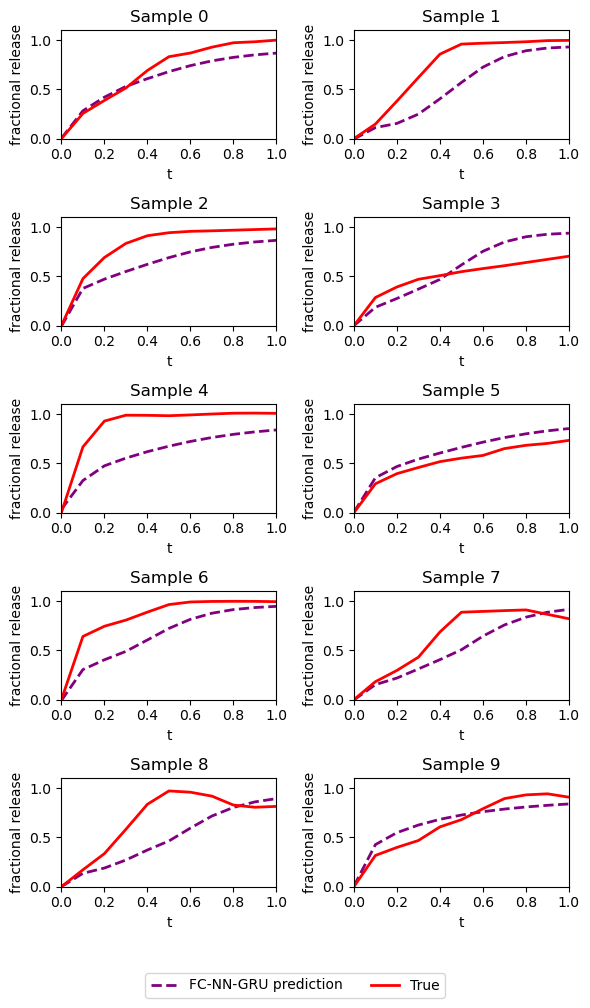

In [19]:
# ----------------------
# Plot example predictions
# ----------------------
x = np.linspace(0, 1, num_interp_pts)
fig, axes = plt.subplots(5, 2, figsize=(6, 10))  # 10 samples total
axes = axes.flatten()

# Plot first 10 samples from the first outer fold
for i in range(10):
    # Each sample spans num_interp_pts consecutive values
    start = i * num_interp_pts
    end = (i + 1) * num_interp_pts

    line1, = axes[i].plot(
        x, stored_best_preds[0][start:end],
        label=f"{model_name} prediction", linestyle='--', lw=2, color='purple'
    )
    line2, = axes[i].plot(
        x, stored_test_targets[0][start:end],
        label="True", linestyle='-', lw=2, color='red'
    )
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("t")
    axes[i].set_ylabel("fractional release")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1.1)

# Add global legend below all plots
fig.legend(
    handles=[line1, line2],
    labels=[f"{model_name} prediction", "True"],
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.01)
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave room for legend
plot_filename = f"{model_name}_prediction.png"
plt.savefig(plot_filename, dpi=300, bbox_inches="tight")
print(f"Saved {plot_filename}")
plt.show()

In [20]:
model_name = "FC-NN_GRU"

#outer_loss_filename = f"{model_name}_outer_loss.csv"
preds_filename = f"{model_name}_preds_vs_targets.csv"
#metrics_filename = f"{model_name}_metrics_summary.csv"
# === Save inner loss curves ===
# Flatten into a DataFrame where each row = (fold, epoch, train_loss, val_loss)

# === Save outer loss curves ===
# Flatten into DataFrame: each row = (outer_fold, epoch, train_loss)
outer_records = []
for fold_idx, train_losses in enumerate(all_outer_train_loss_curves_best, start=1):
    for epoch, tr in enumerate(train_losses, start=1):
        outer_records.append({
            "outer_fold": fold_idx,
            "epoch": epoch,
            "train_loss": tr
        })

df_outer = pd.DataFrame(outer_records)
#df_outer.to_csv(outer_loss_filename, index=False)
#print(f"Saved {outer_loss_filename}")

pred_records = []
for fold_idx, (preds, targets) in enumerate(zip(stored_best_preds, stored_test_targets), start=1):
    # Ensure same length
    length = min(len(preds), len(targets))
    for i in range(length):
        pred_records.append({
            "outer_fold": fold_idx,
            "index": i,
            "y_true": targets[i],
            "y_pred": preds[i]
        })

df_preds = pd.DataFrame(pred_records)
df_preds.to_csv(preds_filename, index=False)
print(f"Saved {preds_filename}")

metrics_records = []
for fold_idx, (mse, rmse, r2, adj_r2) in enumerate(zip(
    stored_best_mse, stored_best_rmse, stored_r2, stored_adj_r2
), start=1):
    metrics_records.append({
        "outer_fold": fold_idx,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Adj_R2": adj_r2
    })

df_metrics = pd.DataFrame(metrics_records)
df_metrics.loc["mean"] = df_metrics.mean(numeric_only=True)   # add mean row
df_metrics.loc["std"] = df_metrics.std(numeric_only=True)     # add std row
#df_metrics.to_csv(metrics_filename, index=True)
#print(f"Saved {metrics_filename}")


Saved FC-NN_GRU_preds_vs_targets.csv
